# Trend Following Principal Components Backtest Analysis

## Pacakges

In [31]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from SignalGenerator import SignalGenerator
from TreasuryDataCollect import TreasuryDataCollect

## Data Prep & Signal Prep

In [2]:
def get_data() -> pd.DataFrame: 
    
    df_tsy_fut = TreasuryDataCollect().get_tsy_fut()

    df_combined = (pd.concat([
        SignalGenerator().ewma_signal().drop(columns = ["value"]),
        SignalGenerator().ewmac_signal().drop(columns = ["value"]),
        SignalGenerator().kalman_signal()]))

    df_out = (df_tsy_fut[
        ["date", "security", "PX_bps"]].
        merge(right = df_combined, how = "inner", on = ["date"]))
    
    return df_out

df_data = get_data()

In [3]:
def _get_signal_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    if df.name == "resid Kalman" or df.name == "smooth Kalman":
        
        df_out = (df.sort_values(
            "date").
            assign(signal_rtn = lambda x: -1 * np.sign(x.lag_signal) * x.PX_bps))
        
    else: 
        
        df_out = (df.sort_values(
            "date").
            assign(signal_rtn = lambda x: np.sign(x.lag_signal) * x.PX_bps))
        
    return df_out
    
def get_signal_rtn(df_data: pd.DataFrame) -> pd.DataFrame: 

    df_signal_rtn = (df_data.groupby(
        "signal_type").
        apply(_get_signal_rtn).
        reset_index(drop = True).
        assign(full_strat = lambda x:
               x.security.str.split(" ").str[0] + "_" + 
               x.variable.str.replace(" ", "-") + "_" + 
               x.strat_name.astype(str) + "_" + 
               x.signal_type.replace(" ", "-")))
    
    return df_signal_rtn

df_signal_rtn = get_signal_rtn(df_data)

## Sharpe Analysis

In [4]:
def get_sharpe(df_signal_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_namer = (df_signal_rtn[
        ["security", "variable", "strat_name", "signal_type", "full_strat"]].
        groupby("full_strat").
        head(1))

    df_sharpe = (df_signal_rtn[
        ["full_strat", "signal_rtn"]].
        groupby("full_strat").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        merge(right = df_namer, how = "inner", on = ["full_strat"]))
    
    return df_sharpe

df_sharpe = get_sharpe(df_signal_rtn)

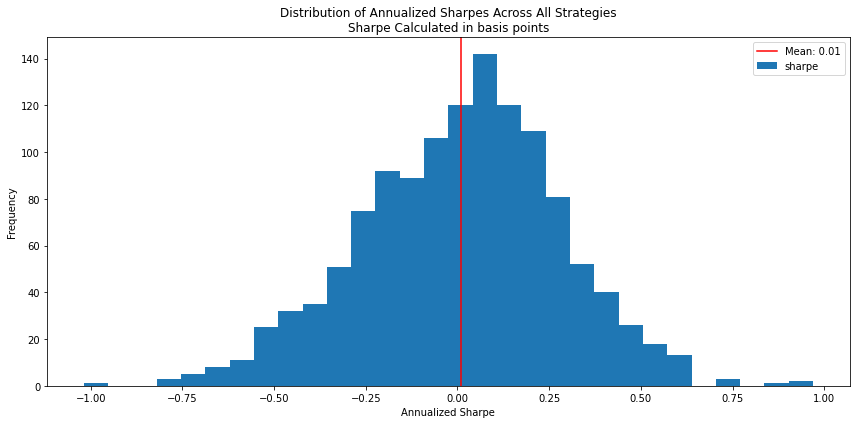

In [5]:
def plot_all_sharpes(df_sharpe: pd.DataFrame) -> plt.Figure:
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_sharpe.sharpe.plot(
        ax      = axes,
        kind    = "hist",
        bins    = 30,
        xlabel  = "Annualized Sharpe",
        title   = "Distribution of Annualized Sharpes Across All Strategies\nSharpe Calculated in basis points"))

    axes.axvline(
        x     = df_sharpe.sharpe.mean(),
        color = "red",
        label = "Mean: {}".format(round(df_sharpe.sharpe.mean(), 2)))

    axes.legend()
    plt.tight_layout()
    
plot_all_sharpes(df_sharpe)

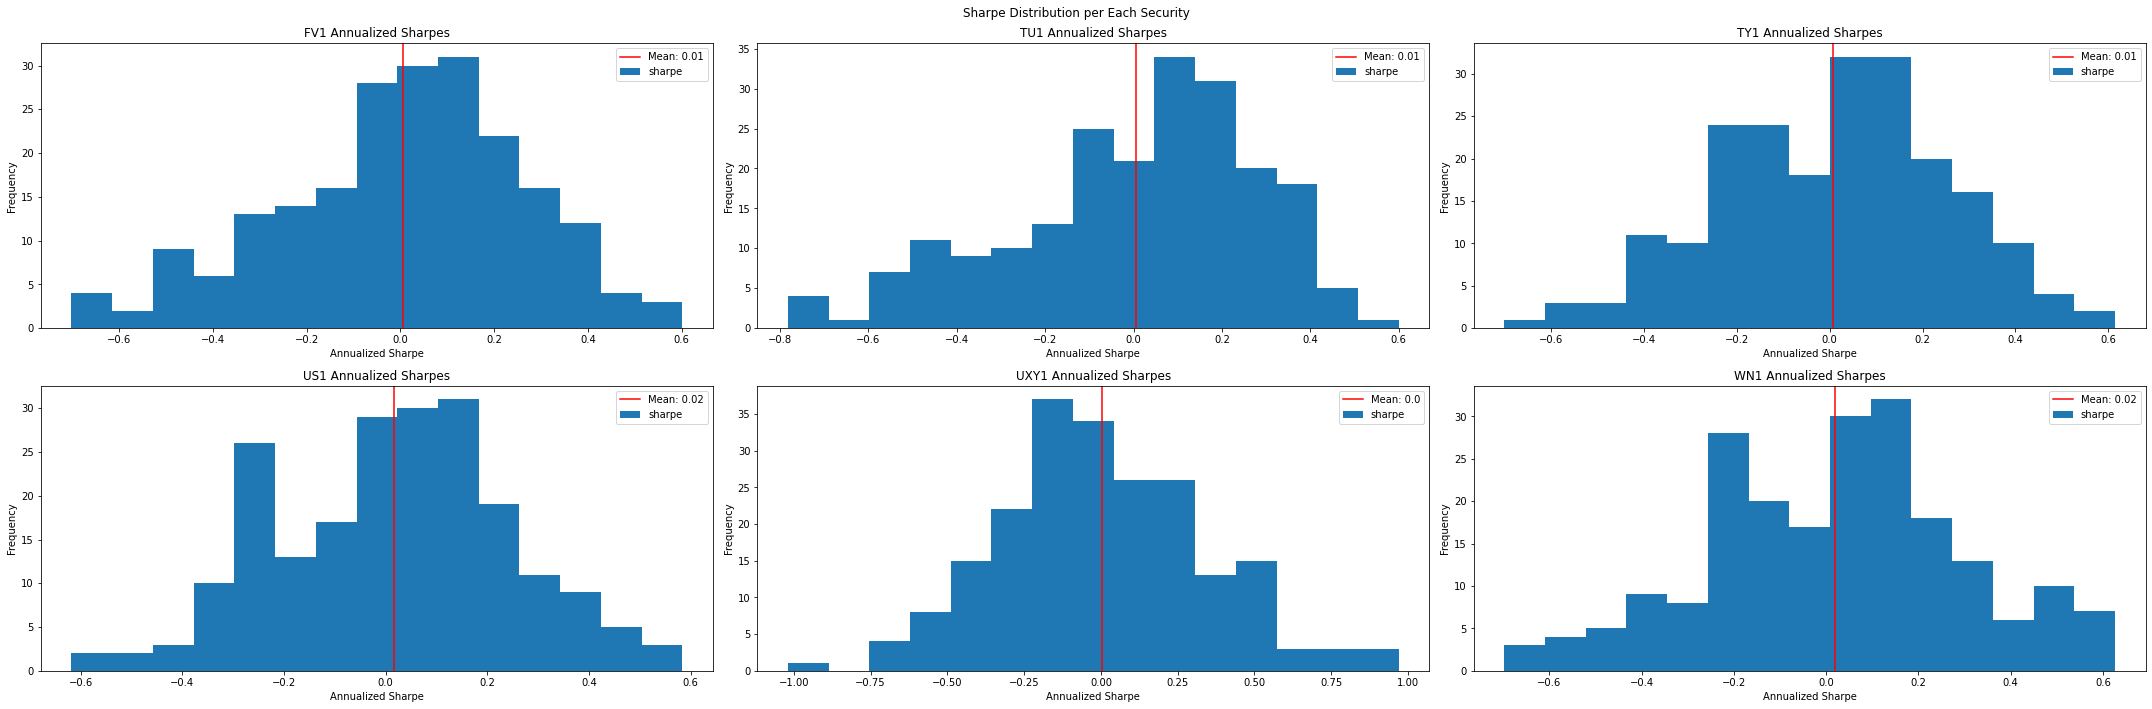

In [6]:
def plot_sharpe_per_security(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    securitys = df_sharpe.security.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(securitys) // 2, nrows = len(securitys) // 3, figsize = (30,10))

    for security, ax in zip(securitys, axes.flatten()): 

        sharpes = (df_sharpe.query(
            "security == @security").
            sharpe)

        sharpes.plot(
            ax     = ax,
            kind   = "hist",
            bins   = 15,
            xlabel = "Annualized Sharpe",
            title  = "{} Annualized Sharpes".format(security.split(" ")[0]))

        ax.axvline(
            x     = sharpes.mean(),
            color = "red",
            label = "Mean: {}".format(round(sharpes.mean(), 2)))

        ax.legend()

    fig.suptitle("Sharpe Distribution per Each Security")
    plt.tight_layout()
    
plot_sharpe_per_security(df_sharpe)

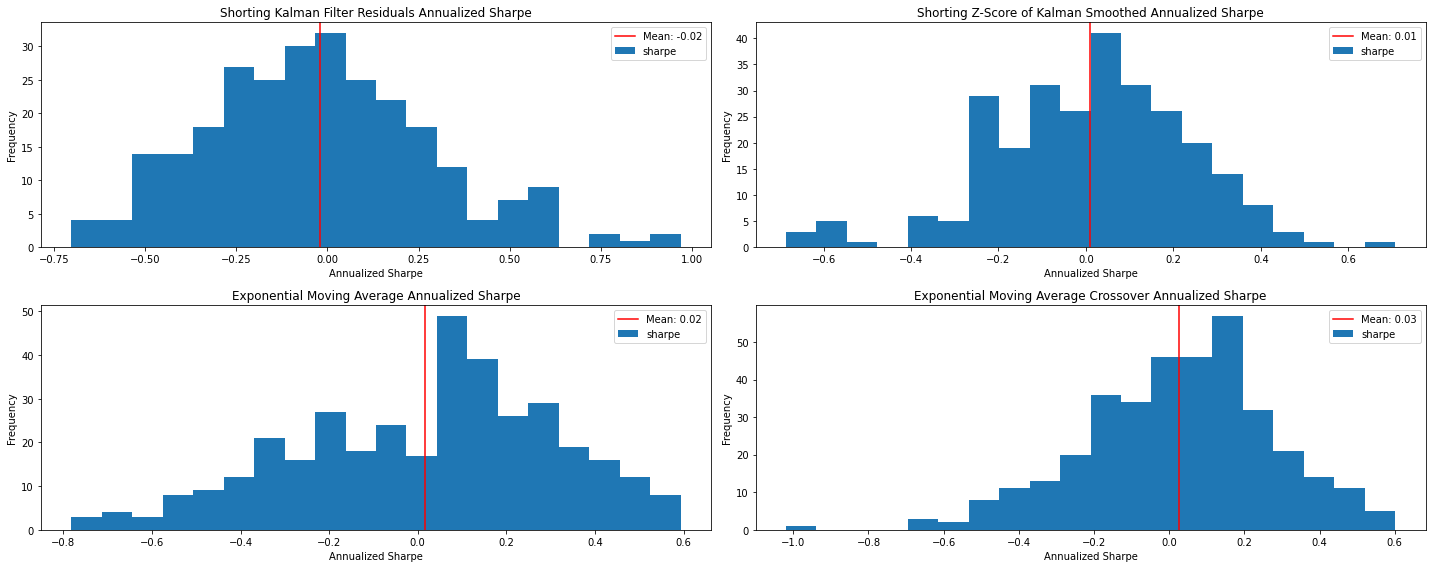

In [26]:
def plot_sharpe_per_signal(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    signal_types = df_sharpe.signal_type.drop_duplicates().to_list()
    fig, axes    = plt.subplots(ncols = len(signal_types) // 2, nrows = len(signal_types) // 2, figsize = (20,8))

    renamer = {
        "resid"    : "Shorting Kalman Filter Residuals",
        "smooth"   : "Shorting Z-Score of Kalman Smoothed",
        "EMATrend" : "Exponential Moving Average",
        "EMACTrend": "Exponential Moving Average Crossover"}

    for signal_type, ax in zip(signal_types, axes.flatten()): 

        sharpes = (df_sharpe.query(
            "signal_type == @signal_type").
            sharpe)

        sharpes.plot(
            ax     = ax,
            kind   = "hist",
            bins   = 20,
            xlabel = "Annualized Sharpe",
            title  = "{} Annualized Sharpe".format(renamer[signal_type.split(" ")[0]]))

        ax.axvline(
            x     = sharpes.mean(),
            color = "red",
            label = "Mean: {}".format(round(sharpes.mean(), 2)))

        ax.legend()

    plt.tight_layout()
    
plot_sharpe_per_signal(df_sharpe)

## Naive Sharpe Estimator

In this case just take rolling 30d sharpe and then get max 10 sharpes per each day 

In [82]:
def _get_rolling_sharpe(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            roll_sharpe = lambda x: x.signal_rtn.rolling(window = window).mean() / x.signal_rtn.rolling(window = window).std(),
            lag_sharpe  = lambda x: x.roll_sharpe.shift()).
        dropna())
    
    return df_out

def get_rolling_sharpe(df_signal_rtn: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_out = (df_signal_rtn.groupby(
        "full_strat").
        apply(_get_rolling_sharpe, window).
        reset_index(drop = True))
    
    return df_out

df_rolling_sharpe = get_rolling_sharpe(df_signal_rtn)

In [85]:
def _get_max_sharpe(df: pd.DataFrame, max_strats: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "lag_sharpe").
        tail(max_strats).
        assign(strat = [i + 1 for i in range(max_strats)]))
    
    return df_out

def get_max_sharpe(df_rolling_sharpe: pd.DataFrame, max_strats: int = 10) -> pd.DataFrame: 
    
    df_tmp = (df_rolling_sharpe.groupby([
        "date", "security"]).
        apply(_get_max_sharpe, max_strats).
        reset_index(drop = True))
    
    return df_tmp

df_max_sharpe = get_max_sharpe(df_rolling_sharpe)

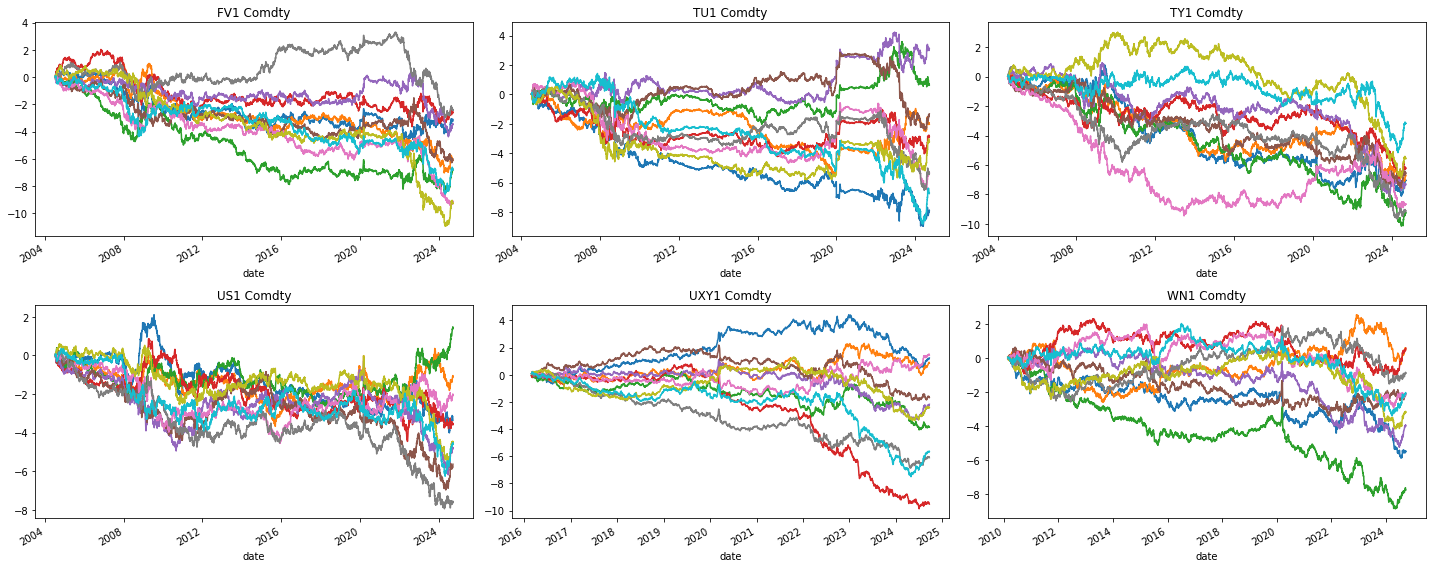

In [88]:
securitys = df_tmp.security.drop_duplicates().sort_values().to_list()
fig, axes = plt.subplots(ncols = len(securitys) // 2, nrows = len(securitys) // 3, figsize = (20,8))

for security, ax in zip(securitys, axes.flatten()):

    (df_tmp.query(
        "security == @security")
        [["date", "strat", "signal_rtn"]].
        pivot(index = "date", columns = "strat", values = "signal_rtn").
        cumsum().
        plot(
            ax = ax,
            legend = False,
            title = security))
    
plt.tight_layout()